<a href="https://colab.research.google.com/github/mattliston/postgraduate_dissertation/blob/master/baseline_glucose_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install --upgrade tensorflow-model-optimization

import numpy as np
import tensorflow as tf
import tensorflow_model_optimization as tfmot
import matplotlib.pyplot as plt
import json
import tempfile
from google.colab import drive

print(tf.__version__)

drive.mount('/content/drive')
%cd /content/drive/My Drive/CGM_prediction_data

     |████████████████████████████████| 174kB 4.7MB/s 
     |████████████████████████████████| 296kB 14.3MB/s 
2.2.0
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/CGM_prediction_data


# TPU Info

In [ ]:
# Optional, faster to use GPU in this case

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

# GPU Info

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sat Jul 11 19:42:56 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    40W / 250W |   1353MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Data pre-processing

In [ ]:
def downscale(data, resolution):

    # 10 min resolution.. (data.shape[0], 3, 1440) -> (data.shape[0], 10, 3, 144).. breaks one 3,1440 length trajectory into ten 3,144 length trajectories
    # Use ~12 timesteps -> 2-5 timesteps (Use ~2 hours to predict 20-50 mins)

    scaled_data = np.zeros((data.shape[0], resolution, data.shape[1], int(data.shape[2]/resolution)))

    for i in range(resolution):
        
        scaled_data[:,i,:,:] = data[:,:,i::resolution]

    return scaled_data


def process_data(aligned_data, time_horizon, ph):

    # 10 min resolution.. breaks each (3,144) trajectory into (144-ph-time_horizon,3,time_horizon) samples

    data = np.zeros((aligned_data.shape[0] * aligned_data.shape[1] * (aligned_data.shape[3]-ph-time_horizon), aligned_data.shape[2], time_horizon))
    label = np.zeros((aligned_data.shape[0] * aligned_data.shape[1] * (aligned_data.shape[3]-ph-time_horizon), ph))

    count = 0
    for i in range(aligned_data.shape[0]): # for each sample
        for j in range(aligned_data.shape[1]): # for each 144 length trajectory
            for k in range(aligned_data.shape[3]-ph-time_horizon): # TH length sliding window across trajectory
                data[count] = aligned_data[i,j,:,k:k+time_horizon]
                label[count] = aligned_data[i,j,0,k+time_horizon:k+time_horizon+ph]
                count+=1     

    return data, label


def load_data(time_horizon, ph, resolution, batch): # int, int, int, bool
    
    # Load train data
    g = np.loadtxt('glucose_readings_train.csv', delimiter=',')
    c = np.loadtxt('meals_carbs_train.csv', delimiter=',') 
    it = np.loadtxt('insulin_therapy_train.csv', delimiter=',')

    # Load test data
    g_ = np.loadtxt('glucose_readings_test.csv', delimiter=',')
    c_ = np.loadtxt('meals_carbs_test.csv', delimiter=',')
    it_ = np.loadtxt('insulin_therapy_test.csv', delimiter=',')

    # Time align train & test data
    aligned_train_data = downscale(np.array([(g[i,:], c[i,:], it[i,:]) for i in range(g.shape[0])]), resolution)
    aligned_test_data = downscale(np.array([(g_[i,:], c_[i,:], it_[i,:]) for i in range(g_.shape[0])]), resolution)

    # Break time aligned data into train & test samples
    if batch:
        train_data, train_label = process_data(aligned_train_data, time_horizon, ph)
        test_data, test_label = process_data(aligned_test_data, time_horizon, ph)
    
        return np.swapaxes(train_data,1,2), train_label, np.swapaxes(test_data,1,2), test_label
      
    else:

        return aligned_train_data, aligned_test_data

In [ ]:
# Sample output shapes for time_horizon = 2hrs, PH = 20 mins, resolution = 10 mins

train_data, train_label, test_data, test_label = load_data(12,2,10)
print(train_data.shape, train_label.shape, test_data.shape, test_label.shape)

(982800, 12, 3) (982800, 2) (421200, 12, 3) (421200, 2)


# Dense network

In [ ]:
def dense_net(ph): # add ph parameter
    
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(512, activation='relu', input_shape=(train_data.shape[1] * train_data.shape[2],)))
    model.add(tf.keras.layers.Dense(512, activation='relu'))
    model.add(tf.keras.layers.Dense(512, activation='relu'))
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(32, activation='relu'))
    model.add(tf.keras.layers.Dense(ph, activation=None))

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError()])

    return model


## TH = 2 hrs, PH = 20 mins


In [ ]:
# Hyper-parameters
PH = 2
TIME_HORIZON = 12
RESOLUTION = 10
BATCH_SIZE = 128
EPOCHS = 50
BATCH = True

train_data, train_label, test_data, test_label = load_data(TIME_HORIZON, PH, RESOLUTION, BATCH)

model = dense_net(PH)

print(model.summary())

dense_net = model.fit(x=np.reshape(train_data, (train_data.shape[0], train_data.shape[1] * train_data.shape[2])),
                      y=train_label,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      validation_data=(np.reshape(test_data, (test_data.shape[0], test_data.shape[1] * test_data.shape[2])), test_label))

# Save model
model.save('saved_models/dense_TH=2hr_PH=20mins.h5')
json.dump(dense_net.history, open('saved_models/dense_net_TH=2hr_PH=20mins_history', 'w'))

!ls saved_models

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 512)               18944     
_________________________________________________________________
dense_8 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_9 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_10 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_11 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_12 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_13 (Dense)             (None, 2)                

## TH = 2 hrs, PH = 30 mins

In [ ]:
# Hyper-parameters
PH = 3
TIME_HORIZON = 12
RESOLUTION = 10
BATCH_SIZE = 128
EPOCHS = 50
BATCH = True

train_data, train_label, test_data, test_label = load_data(TIME_HORIZON, PH, RESOLUTION, BATCH)

model = dense_net(PH)

print(model.summary())

dense_net = model.fit(x=np.reshape(train_data, (train_data.shape[0], train_data.shape[1] * train_data.shape[2])),
                      y=train_label,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      validation_data=(np.reshape(test_data, (test_data.shape[0], test_data.shape[1] * test_data.shape[2])), test_label))

# Save model
model.save('saved_models/dense_TH=2hr_PH=30mins.h5')
json.dump(dense_net.history, open('saved_models/dense_TH=2hr_PH=30mins_history', 'w'))

!ls saved_models

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               18944     
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 9

# CNN

In [ ]:
def cnn(ph):

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv1D(128, 5, activation='relu', padding='same', input_shape=(train_data.shape[1], train_data.shape[2])))
    model.add(tf.keras.layers.MaxPool1D(pool_size=2, strides=1, padding='valid'))
    model.add(tf.keras.layers.Conv1D(256, 3, activation='relu', padding='same'))
    model.add(tf.keras.layers.MaxPool1D(pool_size=2, strides=1, padding='valid'))
    model.add(tf.keras.layers.Conv1D(256, 3, activation='relu', padding='same'))
    model.add(tf.keras.layers.MaxPool1D(pool_size=2, strides=1, padding='valid'))
    model.add(tf.keras.layers.Conv1D(512, 3, activation='relu', padding='same'))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(ph, activation=None))

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError()])

    return model

## TH = 2 hrs, PH = 20 mins

In [ ]:
PH = 2
TIME_HORIZON = 12
RESOLUTION = 10
BATCH_SIZE = 128
EPOCHS = 50
BATCH = True

train_data, train_label, test_data, test_label = load_data(TIME_HORIZON, PH, RESOLUTION, BATCH)

print(train_data.shape, test_data.shape)

model = cnn(PH)

print(model.summary())

cnn = model.fit(x=train_data,
                y=train_label,
                batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                validation_data=(test_data, test_label))

# Save model
model.save('saved_models/cnn_TH=2hr_PH=20mins.h5')
json.dump(cnn.history, open('saved_models/cnn_TH=2hr_PH=20mins_history', 'w'))

!ls saved_models

(982800, 12, 3) (421200, 12, 3)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 12, 128)           2048      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 11, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 11, 256)           98560     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 10, 256)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 10, 256)           196864    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 9, 256)            0         
_________________________________________________________________
conv1d_3 (Conv1D)     

## TH = 2hrs, PH = 30 mins

In [ ]:
PH = 3
TIME_HORIZON = 12
RESOLUTION = 10
BATCH_SIZE = 128
EPOCHS = 50
BATCH = True

train_data, train_label, test_data, test_label = load_data(TIME_HORIZON, PH, RESOLUTION, BATCH)

print(train_data.shape, test_data.shape)

model = cnn(PH)

print(model.summary())

cnn = model.fit(x=train_data,
                y=train_label,
                batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                validation_data=(test_data, test_label))

# Save model
model.save('saved_models/cnn_TH=2hrs_PH=30mins.h5')
json.dump(cnn.history, open('saved_models/cnn_TH=2hrs_PH=30mins_history', 'w'))

!ls saved_models

(975240, 12, 3) (417960, 12, 3)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 12, 128)           2048      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 11, 128)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 11, 256)           98560     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 10, 256)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 10, 256)           196864    
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 9, 256)            0         
_________________________________________________________________
conv1d_7 (Conv1D)     

# LSTM

In [ ]:
def lstm(ph):

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(200, return_sequences=True, input_shape=(train_data.shape[1], train_data.shape[2])))
    model.add(tf.keras.layers.LSTM(200, return_sequences=True))
    model.add(tf.keras.layers.LSTM(200, return_sequences=True))
    model.add(tf.keras.layers.LSTM(ph, activation=None))
#    model.add(tf.keras.layers.Dense(1000))
#    model.add(tf.keras.layers.Dense(250))
#    model.add(tf.keras.layers.Dense(ph, activation=None))

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError()])

    return model

## TH = 2hrs, PH = 20mins

In [ ]:
PH = 2
TIME_HORIZON = 12
RESOLUTION = 10
BATCH_SIZE = 128
EPOCHS = 50
BATCH = True

train_data, train_label, test_data, test_label = load_data(TIME_HORIZON, PH, RESOLUTION, BATCH)

print(train_data.shape, test_data.shape)

model = lstm(PH)

print(model.summary())

lstm = model.fit(x=train_data,
                 y=train_label,
                 batch_size=BATCH_SIZE,
                 epochs=EPOCHS,
                 validation_data=(test_data, test_label))

model.save('saved_models/lstm_TH=2hrs_PH=20mins.h5')
json.dump(lstm.history, open('saved_models/lstm_TH=2hrs_PH=20mins_history', 'w'))

!ls saved_models

(982800, 12, 3) (421200, 12, 3)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 12, 200)           163200    
_________________________________________________________________
lstm_1 (LSTM)                (None, 12, 200)           320800    
_________________________________________________________________
lstm_2 (LSTM)                (None, 12, 200)           320800    
_________________________________________________________________
lstm_3 (LSTM)                (None, 2)                 1624      
Total params: 806,424
Trainable params: 806,424
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
7679/7679 [==============================] - 204s 27ms/step - loss: 3.6080 - root_mean_squared_error: 1.8995 - val_loss: 0.1058 - val_root_mean_squared_error: 0.3253
Epoch 2/50
7679/7679 [============

## TH = 2hrs, PH = 30 mins

In [ ]:
PH = 3
TIME_HORIZON = 12
RESOLUTION = 10
BATCH_SIZE = 128
EPOCHS = 50
BATCH = True

train_data, train_label, test_data, test_label = load_data(TIME_HORIZON, PH, RESOLUTION, BATCH)

print(train_data.shape, test_data.shape)

model = lstm(PH)

print(model.summary())

lstm = model.fit(x=train_data,
                 y=train_label,
                 batch_size=BATCH_SIZE,
                 epochs=EPOCHS,
                 validation_data=(test_data, test_label))

model.save('saved_models/lstm_TH=2hrs_PH=30mins.h5')
json.dump(lstm.history, open('saved_models/lstm_TH=2hrs_PH=30mins_history', 'w'))

!ls saved_models

(975240, 12, 3) (417960, 12, 3)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 12, 200)           163200    
_________________________________________________________________
lstm_1 (LSTM)                (None, 12, 200)           320800    
_________________________________________________________________
lstm_2 (LSTM)                (None, 12, 200)           320800    
_________________________________________________________________
lstm_3 (LSTM)                (None, 3)                 2448      
Total params: 807,248
Trainable params: 807,248
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
7620/7620 [==============================] - 204s 27ms/step - loss: 0.2298 - root_mean_squared_error: 0.4794 - val_loss: 0.1209 - val_root_mean_squared_error: 0.3476
Epoch 2/50
7620/7620 [============

# CRNN

In [ ]:
def crnn(ph):

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv1D(128, 4, activation='relu', padding='same', input_shape=(train_data.shape[1], train_data.shape[2])))
    model.add(tf.keras.layers.MaxPool1D(pool_size=2, strides=1, padding='same'))
    model.add(tf.keras.layers.Conv1D(256, 4, activation='relu', padding='same'))
    model.add(tf.keras.layers.MaxPool1D(pool_size=2, strides=1, padding='same'))
    model.add(tf.keras.layers.Conv1D(512, 4, activation='relu', padding='same'))
    model.add(tf.keras.layers.MaxPool1D(pool_size=2, strides=1, padding='same'))
    model.add(tf.keras.layers.LSTM(200, return_sequences=True))
    model.add(tf.keras.layers.LSTM(200, return_sequences=True))
    model.add(tf.keras.layers.LSTM(200, return_sequences=True))
#    model.add(tf.keras.layers.Dense(256, activation='relu'))
#    model.add(tf.keras.layers.Dense(32, activation='relu'))
    model.add(tf.keras.layers.LSTM(ph, activation=None))

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError()])

    return model

## TH = 2hrs, PH = 20 mins

In [ ]:
PH = 2
TIME_HORIZON = 12
RESOLUTION = 10
BATCH_SIZE = 128
EPOCHS = 50
BATCH = True # indicates whether to convert data into batches

train_data, train_label, test_data, test_label = load_data(TIME_HORIZON, PH, RESOLUTION, BATCH)

model = crnn(PH)

print(model.summary())

crnn = model.fit(x=train_data,
                 y=train_label,
                 batch_size=BATCH_SIZE,
                 epochs=EPOCHS,
                 validation_data=(test_data, test_label))

model.save('saved_models/crnn_TH=2hrs_PH=20mins.h5')
json.dump(crnn.history, open('saved_models/crnn_TH=2hrs_PH=20mins_history', 'w'))

!ls saved_models

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 12, 128)           1664      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 12, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 12, 256)           131328    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 12, 256)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 12, 512)           524800    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 12, 512)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 12, 200)          

## TH = 2hrs, PH = 30 mins

In [ ]:
PH = 3
TIME_HORIZON = 12
RESOLUTION = 10
BATCH_SIZE = 128
EPOCHS = 50
BATCH = True

train_data, train_label, test_data, test_label = load_data(TIME_HORIZON, PH, RESOLUTION, BATCH)

model = crnn(PH)

print(model.summary())

crnn = model.fit(x=train_data,
                 y=train_label,
                 batch_size=BATCH_SIZE,
                 epochs=EPOCHS,
                 validation_data=(test_data, test_label))

model.save('saved_models/crnn_TH=2hrs_PH=30mins.h5')
json.dump(crnn.history, open('saved_models/crnn_TH=2hrs_PH=30mins_history', 'w'))

!ls saved_models

# Bidirectional LSTM

In [ ]:
def bilstm(ph):

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200, return_sequences=True)))
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200, return_sequences=True)))
    model.add(tf.keras.layers.Flatten())
  #  model.add(tf.keras.layers.Dense(264, activation='relu'))
  #  model.add(tf.keras.layers.Dropout(rate=0.5))
  #  model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dense(ph))

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError()])

    return model

## TH = 2hrs, PH = 20 mins

In [ ]:
PH = 2
TIME_HORIZON = 12
RESOLUTION = 10
BATCH_SIZE = 128
EPOCHS = 50
BATCH = True # indicates whether to convert data into batches

train_data, train_label, test_data, test_label = load_data(TIME_HORIZON, PH, RESOLUTION, BATCH)

model = bilstm(PH)

#print(model.summary())

bilstm = model.fit(x=train_data,
                   y=train_label,
                   batch_size=BATCH_SIZE,
                   epochs=EPOCHS,
                   validation_data=(test_data, test_label))

print(model.summary())

model.save('saved_models/bilstm_TH=2hrs_PH=20mins.h5')
json.dump(bilstm.history, open('saved_models/bilstm_TH=2hrs_PH=20mins_history', 'w'))

!ls saved_models

Epoch 1/50
7679/7679 [==============================] - 92s 12ms/step - loss: 0.1549 - root_mean_squared_error: 0.3935 - val_loss: 0.1046 - val_root_mean_squared_error: 0.3234
Epoch 2/50
7679/7679 [==============================] - 92s 12ms/step - loss: 0.1017 - root_mean_squared_error: 0.3189 - val_loss: 0.0973 - val_root_mean_squared_error: 0.3120
Epoch 3/50
7679/7679 [==============================] - 91s 12ms/step - loss: 0.0978 - root_mean_squared_error: 0.3127 - val_loss: 0.1002 - val_root_mean_squared_error: 0.3165
Epoch 4/50
7679/7679 [==============================] - 90s 12ms/step - loss: 0.0955 - root_mean_squared_error: 0.3090 - val_loss: 0.0948 - val_root_mean_squared_error: 0.3080
Epoch 5/50
7679/7679 [==============================] - 91s 12ms/step - loss: 0.0940 - root_mean_squared_error: 0.3066 - val_loss: 0.1011 - val_root_mean_squared_error: 0.3180
Epoch 6/50
7679/7679 [==============================] - 90s 12ms/step - loss: 0.0928 - root_mean_squared_error: 0.3046 -

## TH = 2hrs, PH = 30 mins

In [ ]:
PH = 3
TIME_HORIZON = 12
RESOLUTION = 10
BATCH_SIZE = 128
EPOCHS = 50
BATCH = True # indicates whether to convert data into batches

train_data, train_label, test_data, test_label = load_data(TIME_HORIZON, PH, RESOLUTION, BATCH)

model = bilstm(PH)

#print(model.summary())

bilstm = model.fit(x=train_data,
                   y=train_label,
                   batch_size=BATCH_SIZE,
                   epochs=EPOCHS,
                   validation_data=(test_data, test_label))

print(model.summary())

model.save('saved_models/bilstm_TH=2hrs_PH=30mins.h5')
json.dump(bilstm.history, open('saved_models/bilstm_TH=2hrs_PH=30mins_history', 'w'))

!ls saved_models

Epoch 1/50
7620/7620 [==============================] - 93s 12ms/step - loss: 0.1726 - root_mean_squared_error: 0.4154 - val_loss: 0.1103 - val_root_mean_squared_error: 0.3322
Epoch 2/50
7620/7620 [==============================] - 92s 12ms/step - loss: 0.1065 - root_mean_squared_error: 0.3263 - val_loss: 0.1067 - val_root_mean_squared_error: 0.3266
Epoch 3/50
7620/7620 [==============================] - 91s 12ms/step - loss: 0.1025 - root_mean_squared_error: 0.3202 - val_loss: 0.1290 - val_root_mean_squared_error: 0.3592
Epoch 4/50
7620/7620 [==============================] - 91s 12ms/step - loss: 0.0998 - root_mean_squared_error: 0.3159 - val_loss: 0.1105 - val_root_mean_squared_error: 0.3324
Epoch 5/50
7620/7620 [==============================] - 90s 12ms/step - loss: 0.0978 - root_mean_squared_error: 0.3127 - val_loss: 0.0996 - val_root_mean_squared_error: 0.3157
Epoch 6/50
7620/7620 [==============================] - 90s 12ms/step - loss: 0.0963 - root_mean_squared_error: 0.3103 -

# Comparison of Glucose Predictive Curves (for first test record)

## TH = 2hrs, PH = 20 mins

(130,) (130, 2) (130, 2)


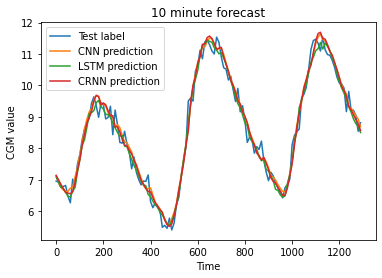

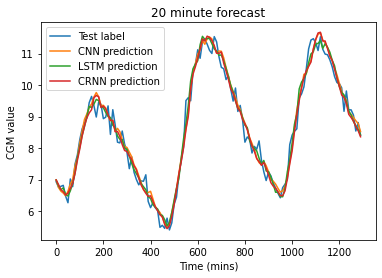

In [ ]:
dense_net = tf.keras.models.load_model('saved_models/dense_TH=2hr_PH=20mins.h5')
cnn = tf.keras.models.load_model('saved_models/cnn_TH=2hr_PH=20mins.h5')
lstm = tf.keras.models.load_model('saved_models/lstm_TH=2hrs_PH=20mins.h5')
crnn = tf.keras.models.load_model('saved_models/crnn_TH=2hrs_PH=20mins.h5')

TIME_HORIZON = 12
PH = 2
RESOLUTION = 10
BATCH = False

train_data, test_data = load_data(TIME_HORIZON, PH, RESOLUTION, BATCH)

test_sample = np.expand_dims(np.expand_dims(test_data[0,0,:,:], axis=0), axis=0) # first trajectory of first sample

test_sample, test_label = process_data(test_sample, TIME_HORIZON, PH)

dense_pred = dense_net.predict(np.reshape(test_sample, (test_sample.shape[0], test_sample.shape[1] * test_sample.shape[2])))
cnn_pred = cnn.predict(np.swapaxes(test_sample,1,2))
lstm_pred = lstm.predict(np.swapaxes(test_sample,1,2))
crnn_pred = crnn.predict(np.swapaxes(test_sample,1,2))


time = np.arange(144-TIME_HORIZON-PH)*10
print(trajectory.shape, dense_pred.shape, test_label.shape)

plt.plot(time, test_label[:,0], label='Test label')
#plt.plot(time, dense_pred[:,0], label='Dense prediction')
plt.plot(time, cnn_pred[:,0], label='CNN prediction')
plt.plot(time, lstm_pred[:,0], label='LSTM prediction')
plt.plot(time, crnn_pred[:,0], label='CRNN prediction')
plt.xlabel('Time')
plt.ylabel('CGM value')
plt.title('10 minute forecast')
plt.legend()
plt.show()

plt.plot(time, test_label[:,1], label='Test label')
#plt.plot(time, dense_pred[:,1], label='Dense prediction')
plt.plot(time, cnn_pred[:,1], label='CNN prediction')
plt.plot(time, lstm_pred[:,1], label='LSTM prediction')
plt.plot(time, crnn_pred[:,1], label='CRNN prediction')
plt.xlabel('Time (mins)')
plt.ylabel('CGM value')
plt.title('20 minute forecast')
plt.legend()
plt.show()

#plt.plot(minutes, test_label[PH+1:1441], label='Test label')
#plt.plot(minutes, lstm_pred, label='LSTM prediction')
#plt.plot(minutes, crnn_pred, label='CRNN prediction')
#plt.xlabel('Time')
#plt.ylabel('CGM value')
#plt.legend()
#plt.show()


## TH = 2hrs, PH = 30 mins

(130,) (129, 3) (129, 3)


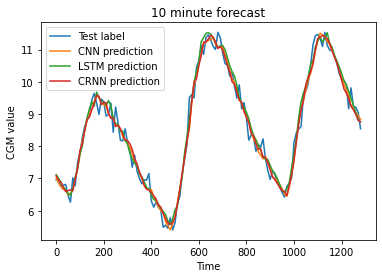

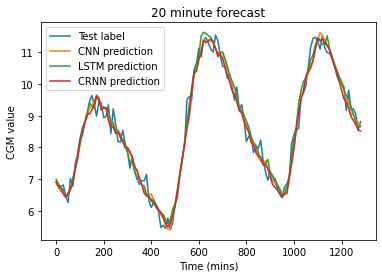

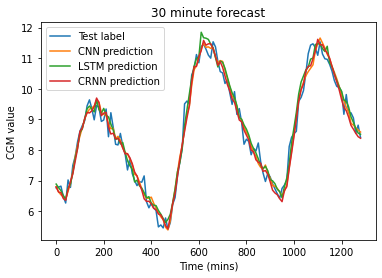

In [ ]:
dense_net = tf.keras.models.load_model('saved_models/dense_TH=2hr_PH=30mins.h5')
cnn = tf.keras.models.load_model('saved_models/cnn_TH=2hrs_PH=30mins.h5')
lstm = tf.keras.models.load_model('saved_models/lstm_TH=2hrs_PH=30mins.h5')
crnn = tf.keras.models.load_model('saved_models/crnn_TH=2hrs_PH=30mins.h5')

TIME_HORIZON = 12
PH = 3
RESOLUTION = 10
BATCH = False

train_data, test_data = load_data(TIME_HORIZON, PH, RESOLUTION, BATCH)

test_sample = np.expand_dims(np.expand_dims(test_data[0,0,:,:], axis=0), axis=0) # first trajectory of first sample

test_sample, test_label = process_data(test_sample, TIME_HORIZON, PH)

dense_pred = dense_net.predict(np.reshape(test_sample, (test_sample.shape[0], test_sample.shape[1] * test_sample.shape[2])))
cnn_pred = cnn.predict(np.swapaxes(test_sample,1,2))
lstm_pred = lstm.predict(np.swapaxes(test_sample,1,2))
crnn_pred = crnn.predict(np.swapaxes(test_sample,1,2))


time = np.arange(144-TIME_HORIZON-PH)*10
print(trajectory.shape, dense_pred.shape, test_label.shape)

plt.plot(time, test_label[:,0], label='Test label')
#plt.plot(time, dense_pred[:,0], label='Dense prediction')
plt.plot(time, cnn_pred[:,0], label='CNN prediction')
plt.plot(time, lstm_pred[:,0], label='LSTM prediction')
plt.plot(time, crnn_pred[:,0], label='CRNN prediction')
plt.xlabel('Time')
plt.ylabel('CGM value')
plt.title('10 minute forecast')
plt.legend()
plt.show()

plt.plot(time, test_label[:,1], label='Test label')
#plt.plot(time, dense_pred[:,1], label='Dense prediction')
plt.plot(time, cnn_pred[:,1], label='CNN prediction')
plt.plot(time, lstm_pred[:,1], label='LSTM prediction')
plt.plot(time, crnn_pred[:,1], label='CRNN prediction')
plt.xlabel('Time (mins)')
plt.ylabel('CGM value')
plt.title('20 minute forecast')
plt.legend()
plt.show()

plt.plot(time, test_label[:,2], label='Test label')
#plt.plot(time, dense_pred[:,2], label='Dense prediction')
plt.plot(time, cnn_pred[:,2], label='CNN prediction')
plt.plot(time, lstm_pred[:,2], label='LSTM prediction')
plt.plot(time, crnn_pred[:,2], label='CRNN prediction')
plt.xlabel('Time (mins)')
plt.ylabel('CGM value')
plt.title('30 minute forecast')
plt.legend()
plt.show()

#plt.plot(minutes, test_label[PH+1:1441], label='Test label')
#plt.plot(minutes, lstm_pred, label='LSTM prediction')
#plt.plot(minutes, crnn_pred, label='CRNN prediction')
#plt.xlabel('Time')
#plt.ylabel('CGM value')
#plt.legend()
#plt.show()


# Comparison of Train & Validation Loss

## TH = 2hrs, PH = 20 mins

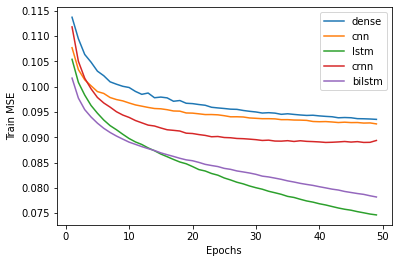

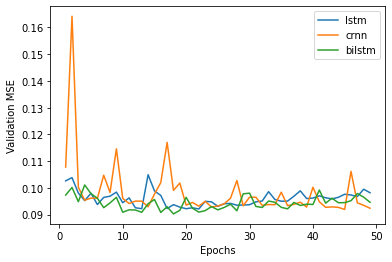

In [ ]:
epochs = np.arange(1,50) # Drop first epoch because it is uninformative # start from maybe epoch 5

dense_train_loss = json.load(open('saved_models/dense_net_TH=2hr_PH=20mins_history'))['loss'][1:]
cnn_train_loss = json.load(open('saved_models/cnn_TH=2hr_PH=20mins_history'))['loss'][1:]
lstm_train_loss = json.load(open('saved_models/lstm_TH=2hrs_PH=20mins_history'))['loss'][1:]
crnn_train_loss = json.load(open('saved_models/crnn_TH=2hrs_PH=20mins_history'))['loss'][1:]
bilstm_train_loss = json.load(open('saved_models/bilstm_TH=2hrs_PH=20mins_history'))['loss'][1:]

plt.plot(epochs, dense_train_loss, label='dense')
plt.plot(epochs, cnn_train_loss, label='cnn')
plt.plot(epochs, lstm_train_loss, label='lstm')
plt.plot(epochs, crnn_train_loss, label='crnn')
plt.plot(epochs, bilstm_train_loss, label='bilstm')
plt.xlabel('Epochs')
plt.ylabel('Train MSE')
plt.legend()
plt.show()

#dense_val_loss = json.load(open('saved_models/dense_net_TH=2hr_PH=20mins_history'))['val_loss'][1:]
#cnn_val_loss = json.load(open('saved_models/cnn_TH=2hr_PH=20mins_history'))['val_loss'][1:]
lstm_val_loss = json.load(open('saved_models/lstm_TH=2hrs_PH=20mins_history'))['val_loss'][1:]
crnn_val_loss = json.load(open('saved_models/crnn_TH=2hrs_PH=20mins_history'))['val_loss'][1:]
bilstm_val_loss = json.load(open('saved_models/bilstm_TH=2hrs_PH=20mins_history'))['val_loss'][1:]

#plt.plot(epochs, dense_val_loss, label='dense')
#plt.plot(epochs, cnn_val_loss, label='cnn')
plt.plot(epochs, lstm_val_loss, label='lstm')
plt.plot(epochs, crnn_val_loss, label='crnn')
plt.plot(epochs, bilstm_val_loss, label='bilstm')
plt.xlabel('Epochs')
plt.ylabel('Validation MSE')
plt.legend()
plt.show()

## TH = 2hrs, PH = 30 mins

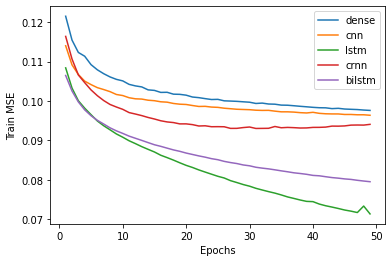

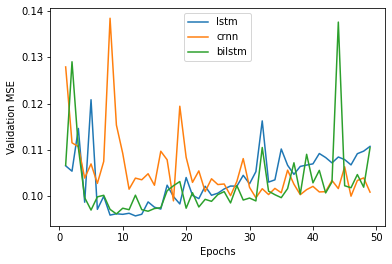

In [ ]:
epochs = np.arange(1,50)

dense_train_loss = json.load(open('saved_models/dense_TH=2hr_PH=30mins_history'))['loss'][1:]
cnn_train_loss = json.load(open('saved_models/cnn_TH=2hrs_PH=30mins_history'))['loss'][1:]
lstm_train_loss = json.load(open('saved_models/lstm_TH=2hrs_PH=30mins_history'))['loss'][1:]
crnn_train_loss = json.load(open('saved_models/crnn_TH=2hrs_PH=30mins_history'))['loss'][1:]
bilstm_train_loss = json.load(open('saved_models/bilstm_TH=2hrs_PH=30mins_history'))['loss'][1:]

plt.plot(epochs, dense_train_loss, label='dense')
plt.plot(epochs, cnn_train_loss, label='cnn')
plt.plot(epochs, lstm_train_loss, label='lstm')
plt.plot(epochs, crnn_train_loss, label='crnn')
plt.plot(epochs, bilstm_train_loss, label='bilstm')
plt.xlabel('Epochs')
plt.ylabel('Train MSE')
plt.legend()
plt.show()

dense_val_loss = json.load(open('saved_models/dense_TH=2hr_PH=30mins_history'))['val_loss'][1:]
cnn_val_loss = json.load(open('saved_models/cnn_TH=2hrs_PH=30mins_history'))['val_loss'][1:]
lstm_val_loss = json.load(open('saved_models/lstm_TH=2hrs_PH=30mins_history'))['val_loss'][1:]
crnn_val_loss = json.load(open('saved_models/crnn_TH=2hrs_PH=30mins_history'))['val_loss'][1:]
bilstm_val_loss = json.load(open('saved_models/bilstm_TH=2hrs_PH=30mins_history'))['val_loss'][1:]

#plt.plot(epochs, dense_val_loss, label='dense')
#plt.plot(epochs, cnn_val_loss, label='cnn')
plt.plot(epochs, lstm_val_loss, label='lstm')
plt.plot(epochs, crnn_val_loss, label='crnn')
plt.plot(epochs, bilstm_val_loss, label='bilstm')
plt.xlabel('Epochs')
plt.ylabel('Validation MSE')
plt.legend()
plt.show()

# Pruned CRNN


## TH = 2hrs, PH = 20 mins

In [ ]:
# Work in progress

PH = 2
TIME_HORIZON = 12
RESOLUTION = 10
BATCH_SIZE = 128
EPOCHS = 50
BATCH = True

train_data, train_label, test_data, test_label = load_data(TIME_HORIZON, PH, RESOLUTION, BATCH)

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.65,
                                                               final_sparsity=0.85,
                                                               begin_step=10,
                                                               end_step=EPOCHS)
}

#with tpu_strategy.scope():
model_for_pruning = prune_low_magnitude(crnn(PH))#tf.keras.models.load_model('saved_models/lstm_TH=2hrs_PH=30mins.h5'), **pruning_params)

model_for_pruning.compile(optimizer='adam',
                          loss='mean_squared_error',
                           metrics=[tf.keras.metrics.RootMeanSquaredError()])

model_for_pruning.summary()

logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]
  
pruned_crnn = model_for_pruning.fit(x=train_data,
                                    y=train_label,
                                    batch_size=BATCH_SIZE,
                                    epochs=EPOCHS,
                                    verbose=2,
                                    validation_data=(test_data, test_label),
                                    callbacks=callbacks)

json.dump(pruned_crnn.history, open('saved_models/pruned_crnn_TH=2hrs_PH=20mins_historyv2', 'w'))

model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)
tf.keras.models.save_model(model_for_export, 'saved_models/pruned_crnn_TH=2hrs_PH=20minsv2.h5', include_optimizer=False)

!ls saved_models

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
prune_low_magnitude_conv1d_3 (None, 12, 128)           3202      
_________________________________________________________________
prune_low_magnitude_max_pool (None, 12, 128)           1         
_________________________________________________________________
prune_low_magnitude_conv1d_4 (None, 12, 256)           262402    
_________________________________________________________________
prune_low_magnitude_max_pool (None, 12, 256)           1         
_________________________________________________________________
prune_low_magnitude_conv1d_5 (None, 12, 512)           1049090   
_________________________________________________________________
prune_low_magnitude_max_pool (None, 12, 512)           1         
_________________________________________________________________
prune_low_magnitude_lstm_41  (None, 12, 200)         

Try fine tuning.

In [ ]:
PH = 2
TIME_HORIZON = 12
RESOLUTION = 10
BATCH_SIZE = 128
EPOCHS = 25
BATCH = True

train_data, train_label, test_data, test_label = load_data(TIME_HORIZON, PH, RESOLUTION, BATCH)

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.98,
                                                               begin_step=0,
                                                               end_step=EPOCHS)
}

model_for_pruning = prune_low_magnitude(tf.keras.models.load_model('saved_models/crnn_TH=2hrs_PH=20mins.h5'), **pruning_params)

model_for_pruning.compile(optimizer='adam',
                          loss='mean_squared_error',
                          metrics=[tf.keras.metrics.RootMeanSquaredError()])

model_for_pruning.summary()

logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]
  
pruned_crnn = model_for_pruning.fit(x=train_data,
                                    y=train_label,
                                    batch_size=BATCH_SIZE,
                                    epochs=EPOCHS,
                                    validation_data=(test_data, test_label),
                                    callbacks=callbacks)

json.dump(pruned_crnn.history, open('saved_models/pruned_crnn_TH=2hrs_PH=20mins_history', 'w'))

model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)
tf.keras.models.save_model(model_for_export, 'saved_models/pruned_crnn_TH=2hrs_PH=20mins.h5', include_optimizer=False)

!ls saved_models

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
prune_low_magnitude_conv1d ( (None, 12, 128)           3202      
_________________________________________________________________
prune_low_magnitude_max_pool (None, 12, 128)           1         
_________________________________________________________________
prune_low_magnitude_conv1d_1 (None, 12, 256)           262402    
_________________________________________________________________
prune_low_magnitude_max_pool (None, 12, 256)           1         
_________________________________________________________________
prune_low_magnitude_conv1d_2 (None, 12, 512)           1049090   
_________________________________________________________________
prune_low_magnitude_max_pool (None, 12, 512)           1         
_________________________________________________________________
prune_low_magnitude_lstm_4 ( (None, 12, 200)          

#### Comparison with CRNN

49 (74,)


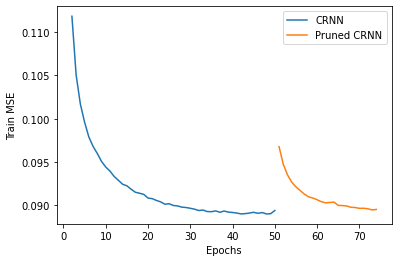

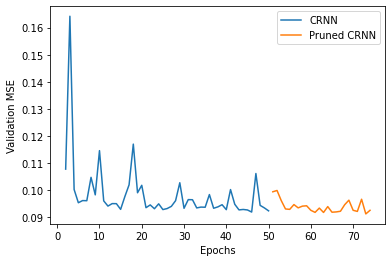

In [ ]:
crnn_train_loss = json.load(open('saved_models/crnn_TH=2hrs_PH=20mins_history'))['loss'][1:]#[26:]
crnn_val_loss = json.load(open('saved_models/crnn_TH=2hrs_PH=20mins_history'))['val_loss'][1:]#[26:]

pruned_crnn_train_loss = json.load(open('saved_models/pruned_crnn_TH=2hrs_PH=20mins_history'))['loss'][1:]
pruned_crnn_val_loss = json.load(open('saved_models/pruned_crnn_TH=2hrs_PH=20mins_history'))['val_loss'][1:]

#epochs = np.arange(26,50)
epochs = np.arange(1,75)

print(len(crnn_train_loss), epochs.shape)

plt.plot(epochs[1:50], crnn_train_loss, label='CRNN')
plt.plot(epochs[50:], pruned_crnn_train_loss, label='Pruned CRNN')
plt.xlabel('Epochs')
plt.ylabel('Train MSE')
plt.legend()
plt.show()

plt.plot(epochs[1:50], crnn_val_loss, label='CRNN')
plt.plot(epochs[50:], pruned_crnn_val_loss, label='Pruned CRNN')
plt.xlabel('Epochs')
plt.ylabel('Validation MSE')
plt.legend()
plt.show()

## TH = 2hrs, PH = 30 mins

In [ ]:
PH = 3
TIME_HORIZON = 12
RESOLUTION = 10
BATCH_SIZE = 64
EPOCHS = 50
BATCH = True

train_data, train_label, test_data, test_label = load_data(TIME_HORIZON, PH, RESOLUTION, BATCH)

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.65,
                                                               final_sparsity=0.95,
                                                               begin_step=10,
                                                               end_step=EPOCHS)
}

#with tpu_strategy.scope():
model_for_pruning = prune_low_magnitude(crnn(PH))#tf.keras.models.load_model('saved_models/lstm_TH=2hrs_PH=30mins.h5'), **pruning_params)

model_for_pruning.compile(optimizer='adam',
                          loss='mean_squared_error',
                           metrics=[tf.keras.metrics.RootMeanSquaredError()])

model_for_pruning.summary()

logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]
  
pruned_crnn = model_for_pruning.fit(x=train_data,
                                    y=train_label,
                                    batch_size=BATCH_SIZE,
                                    epochs=EPOCHS,
                                    verbose=2,
                                    validation_data=(test_data, test_label),
                                    callbacks=callbacks)

json.dump(pruned_crnn.history, open('saved_models/pruned_crnn_TH=2hrs_PH=30mins_history', 'w'))

model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)
tf.keras.models.save_model(model_for_export, 'saved_models/pruned_crnn_TH=2hrs_PH=30mins.h5', include_optimizer=False)

!ls saved_models

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
prune_low_magnitude_conv1d_6 (None, 12, 128)           3202      
_________________________________________________________________
prune_low_magnitude_max_pool (None, 12, 128)           1         
_________________________________________________________________
prune_low_magnitude_conv1d_7 (None, 12, 256)           262402    
_________________________________________________________________
prune_low_magnitude_max_pool (None, 12, 256)           1         
_________________________________________________________________
prune_low_magnitude_conv1d_8 (None, 12, 512)           1049090   
_________________________________________________________________
prune_low_magnitude_max_pool (None, 12, 512)           1         
_________________________________________________________________
prune_low_magnitude_lstm_8 ( (None, 12, 200)          

#### Comparison with CRNN

49 (49,)


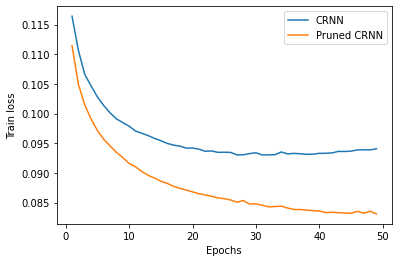

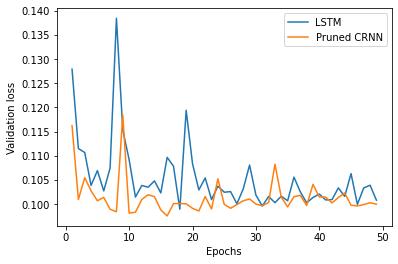

In [ ]:
crnn_train_loss = json.load(open('saved_models/crnn_TH=2hrs_PH=30mins_history'))['loss'][1:]
crnn_val_loss = json.load(open('saved_models/crnn_TH=2hrs_PH=30mins_history'))['val_loss'][1:]

pruned_crnn_train_loss = json.load(open('saved_models/pruned_crnn_TH=2hrs_PH=30mins_history'))['loss'][1:]
pruned_crnn_val_loss = json.load(open('saved_models/pruned_crnn_TH=2hrs_PH=30mins_history'))['val_loss'][1:]

epochs = np.arange(1,50)

print(len(crnn_train_loss), epochs.shape)

plt.plot(epochs, crnn_train_loss, label='CRNN')
plt.plot(epochs, pruned_crnn_train_loss, label='Pruned CRNN')
plt.xlabel('Epochs')
plt.ylabel('Train loss')
plt.legend()
plt.show()

plt.plot(epochs, crnn_val_loss, label='LSTM')
plt.plot(epochs, pruned_crnn_val_loss, label='Pruned CRNN')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()
plt.show()

LSTM seems to be the best performing architecture.  Below I try pruning around ~10 epochs for 30 min PH and ~20 epochs for 20 min PH to see if it helps with overfitting.

# Pruned LSTM

## TH = 2hrs, PH = 20 mins

In [ ]:
PH = 2
TIME_HORIZON = 12
RESOLUTION = 10
BATCH_SIZE = 128
EPOCHS = 50
BATCH = True

train_data, train_label, test_data, test_label = load_data(TIME_HORIZON, PH, RESOLUTION, BATCH)

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.98,
                                                               begin_step=15,
                                                               end_step=EPOCHS)
}

model_for_pruning = prune_low_magnitude(lstm(PH))#tf.keras.models.load_model('saved_models/lstm_TH=2hrs_PH=20mins.h5'), **pruning_params)

model_for_pruning.compile(optimizer='adam',
                          loss='mean_squared_error',
                          metrics=[tf.keras.metrics.RootMeanSquaredError()])

model_for_pruning.summary()

logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]
  
pruned_lstm = model_for_pruning.fit(x=train_data,
                                    y=train_label,
                                    batch_size=BATCH_SIZE,
                                    epochs=EPOCHS,
                                    validation_data=(test_data, test_label),
                                    callbacks=callbacks)

json.dump(pruned_lstm.history, open('saved_models/pruned_lstm_TH=2hrs_PH=20mins_history', 'w'))

model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)
tf.keras.models.save_model(model_for_export, 'saved_models/pruned_lstm_TH=2hrs_PH=20mins.h5', include_optimizer=False)

!ls saved_models

Instructions for updating:
Please use `layer.add_weight` method instead.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
prune_low_magnitude_lstm (Pr (None, 12, 200)           325603    
_________________________________________________________________
prune_low_magnitude_lstm_1 ( (None, 12, 200)           640803    
_________________________________________________________________
prune_low_magnitude_lstm_2 ( (None, 12, 200)           640803    
_________________________________________________________________
prune_low_magnitude_lstm_3 ( (None, 2)                 3243      
Total params: 1,610,452
Trainable params: 806,424
Non-trainable params: 804,028
_________________________________________________________________
Epoch 1/50
7679/7679 [==============================] - 273s 35ms/step - loss: 0.2306 - root_mean_squared_error: 0.4802 - val_loss: 0.1040 - val_root_mean_squared_erro

#### Comparison with LSTM

49 (49,)


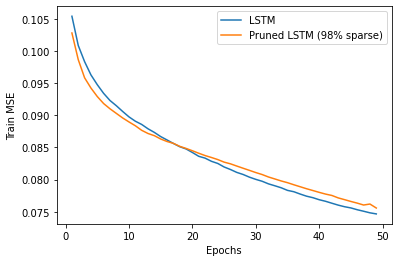

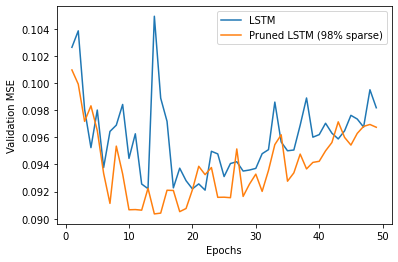

In [ ]:
lstm_train_loss = json.load(open('saved_models/lstm_TH=2hrs_PH=20mins_history'))['loss'][1:]
lstm_val_loss = json.load(open('saved_models/lstm_TH=2hrs_PH=20mins_history'))['val_loss'][1:]

pruned_lstm_train_loss = json.load(open('saved_models/pruned_lstm_TH=2hrs_PH=20mins_history'))['loss'][1:]
pruned_lstm_val_loss = json.load(open('saved_models/pruned_lstm_TH=2hrs_PH=20mins_history'))['val_loss'][1:]

epochs = np.arange(1,50)

print(len(lstm_train_loss), epochs.shape)

plt.plot(epochs, lstm_train_loss, label='LSTM')
plt.plot(epochs, pruned_lstm_train_loss, label='Pruned LSTM (98% sparse)')
plt.xlabel('Epochs')
plt.ylabel('Train MSE')
plt.legend()
plt.show()

plt.plot(epochs, lstm_val_loss, label='LSTM')
plt.plot(epochs, pruned_lstm_val_loss, label='Pruned LSTM (98% sparse)')
plt.xlabel('Epochs')
plt.ylabel('Validation MSE')
plt.legend()
plt.show()

## TH = 2hrs, PH = 30 mins

In [ ]:
PH = 3
TIME_HORIZON = 12
RESOLUTION = 10
BATCH_SIZE = 128
EPOCHS = 50
BATCH = True

train_data, train_label, test_data, test_label = load_data(TIME_HORIZON, PH, RESOLUTION, BATCH)

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.75,
                                                               final_sparsity=0.95,
                                                               begin_step=15,
                                                               end_step=EPOCHS)
}

model_for_pruning = prune_low_magnitude(lstm(PH))#tf.keras.models.load_model('saved_models/lstm_TH=2hrs_PH=30mins.h5'), **pruning_params)

model_for_pruning.compile(optimizer='adam',
                          loss='mean_squared_error',
                          metrics=[tf.keras.metrics.RootMeanSquaredError()])

model_for_pruning.summary()

logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]
  
pruned_lstm = model_for_pruning.fit(x=train_data,
                                    y=train_label,
                                    batch_size=BATCH_SIZE,
                                    epochs=EPOCHS,
                                    verbose=2,
                                    validation_data=(test_data, test_label),
                                    callbacks=callbacks)

json.dump(pruned_lstm.history, open('saved_models/pruned_lstm_TH=2hrs_PH=30mins_history', 'w'))

model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)
tf.keras.models.save_model(model_for_export, 'saved_models/pruned_lstm_TH=2hrs_PH=30mins.h5', include_optimizer=False)

!ls saved_models

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
prune_low_magnitude_lstm_4 ( (None, 12, 200)           325603    
_________________________________________________________________
prune_low_magnitude_lstm_5 ( (None, 12, 200)           640803    
_________________________________________________________________
prune_low_magnitude_lstm_6 ( (None, 12, 200)           640803    
_________________________________________________________________
prune_low_magnitude_lstm_7 ( (None, 3)                 4887      
Total params: 1,612,096
Trainable params: 807,248
Non-trainable params: 804,848
_________________________________________________________________
Epoch 1/50
7620/7620 - 235s - loss: 0.3806 - root_mean_squared_error: 0.6170 - val_loss: 0.1423 - val_root_mean_squared_error: 0.3772
Epoch 2/50
7620/7620 - 234s - loss: 0.1089 - root_mean_squared_error: 0.3300 - val_loss: 0.1041 - val_ro

#### Comparison with LSTM

49 (49,)


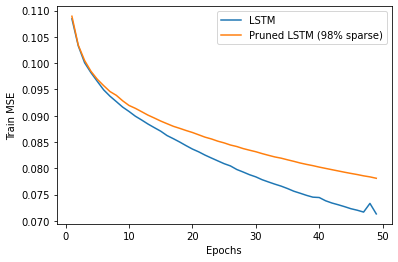

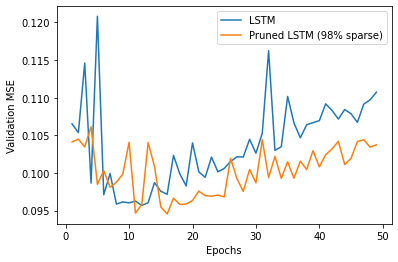

In [ ]:
lstm_train_loss = json.load(open('saved_models/lstm_TH=2hrs_PH=30mins_history'))['loss'][1:]
lstm_val_loss = json.load(open('saved_models/lstm_TH=2hrs_PH=30mins_history'))['val_loss'][1:]

pruned_lstm_train_loss = json.load(open('saved_models/pruned_lstm_TH=2hrs_PH=30mins_history'))['loss'][1:]
pruned_lstm_val_loss = json.load(open('saved_models/pruned_lstm_TH=2hrs_PH=30mins_history'))['val_loss'][1:]

epochs = np.arange(1,50)

print(len(lstm_train_loss), epochs.shape)

plt.plot(epochs, lstm_train_loss, label='LSTM')
plt.plot(epochs, pruned_lstm_train_loss, label='Pruned LSTM (98% sparse)')
plt.xlabel('Epochs')
plt.ylabel('Train MSE')
plt.legend()
plt.show()

plt.plot(epochs, lstm_val_loss, label='LSTM')
plt.plot(epochs, pruned_lstm_val_loss, label='Pruned LSTM (98% sparse)')
plt.xlabel('Epochs')
plt.ylabel('Validation MSE')
plt.legend()
plt.show()

# Pruned Bidirectional LSTM

In [ ]:
#class PruneBidirectional(tf.keras.layers.Bidirectional, tfmot.sparsity.keras.PrunableLayer):
#    def get_prunable_weights(self):
#        return self.forward_layer._trainable_weights + self.backward_layer._trainable_weights

def pruned_bilstm(ph):

    model = tf.keras.Sequential()
    model.add(tfmot.sparsity.keras.prune_low_magnitude(tf.keras.layers.LSTM(200, return_sequences=True)))
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200)))
    model.add(tf.keras.layers.Dense(ph))

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError()])

    return model


## TH = 2hrs, PH = 20 mins

In [ ]:
# Work in progress

PH = 2
TIME_HORIZON = 12
RESOLUTION = 10
BATCH_SIZE = 128
EPOCHS = 50
BATCH = True

train_data, train_label, test_data, test_label = load_data(TIME_HORIZON, PH, RESOLUTION, BATCH)

#prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

model_for_pruning = pruned_bilstm(PH)

pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.95,
                                                               begin_step=15,
                                                               end_step=EPOCHS)
}


#model_for_pruning = prune_low_magnitude(tf.keras.models.load_model('saved_models/bilstm_TH=2hrs_PH=20mins.h5'), **pruning_params)

#model_for_pruning.compile(optimizer='adam',
#                          loss='mean_squared_error',
#                          metrics=[tf.keras.metrics.RootMeanSquaredError()])

#model_for_pruning.summary()

logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]
  
pruned_bilstm = model_for_pruning.fit(x=train_data,
                                      y=train_label,
                                      batch_size=BATCH_SIZE,
                                      epochs=EPOCHS,
                                      validation_data=(test_data, test_label),
                                      callbacks=callbacks)

json.dump(pruned_bilstm.history, open('saved_models/pruned_bilstm_TH=2hrs_PH=20mins_history', 'w'))

model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)
tf.keras.models.save_model(model_for_export, 'saved_models/pruned_bilstm_TH=2hrs_PH=20mins.h5', include_optimizer=False)

!ls saved_models

# Simglucose Experiments

In [ ]:
!pip3 install simglucose

     |████████████████████████████████| 40kB 2.3MB/s 
     |████████████████████████████████| 163kB 7.9MB/s 
     |████████████████████████████████| 225kB 10.9MB/s 
     |████████████████████████████████| 112kB 13.5MB/s 
     |████████████████████████████████| 133kB 13.2MB/s 
  Created wheel for gym: filename=gym-0.9.4-cp36-none-any.whl size=215483 sha256=d1c650bf9105bf9aea5d24a3c77d2dd82ff1ab09c71c8390a9234a1842409229
  Stored in directory: /root/.cache/pip/wheels/2f/ae/a0/126678adc5f1f8905309a4712ea29537999787f610edbcb0a4
  Created wheel for pathos: filename=pathos-0.2.6-cp36-none-any.whl size=77673 sha256=5ece9e9d527500fe4cb967179854665a153bdaaede5ceaf1fccc90c3104437ba
  Stored in directory: /root/.cache/pip/wheels/3a/e8/c8/04cdd0c4bc6fbce35f642fc004244228916daae74bb0f482da
  Created wheel for ppft: filename=ppft-1.6.6.2-cp36-none-any.whl size=64743 sha256=c2b4980f622031e89149961c9a6ab9f99d1ae18f9e15ec1e81d8dcd967f0eff9
  Stored in directory: /root/.cache/pip/wheels/db/d2/2d/0ee21ed

In [ ]:
from simglucose.simulation.user_interface import simulate
simulate(animate=True, )

Show animation? (y/n) y
Use multiple processes? (y/n) y


KeyboardInterrupt: ignored